In [1]:
import argparse
import os 
import csv
import wandb
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pickle

import torch
import torch.nn as nn
import torch.optim as optim
from timm import optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torchvision
from torchvision import models
import timm
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, default_collate
import random
from tqdm import tqdm
import time
import yaml

from Dataset_ML import *
from utils_ML import *
from models_ML import *
import vidaug.augmentors as va

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.metrics import roc_curve

import math
from sklearn.preprocessing import OneHotEncoder

from glob import glob
import cv2

In [2]:
def set_all_seeds(SEED):
    # REPRODUCIBILITY
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(SEED)
    random.seed(SEED)

In [3]:
def num_parameters(module):
    return sum(p.numel() for p in module.parameters() if p.requires_grad)

def collate_video(batch_list):
    """
    A custom collate function to be passed to the callate_fn argument when creating a pytorch dataloader.
    This is necessary because videos have different lengths. We handle by combining all videos along the time 
    dimension and returning the number of frames in each video.
    """
    vids = torch.concat([b[0] for b in batch_list])
    # num_frames = [b.shape[0] for b in batch_list]
    labels = [b[1] for b in batch_list]
    paths = [b[2] for b in batch_list]
    # record = {
    #     'video': vids,
    #     'num_frames': num_frames
    # }

    # use pytorch's default collate function for remaining items
    # for b in batch_list:
    #     b.pop('video')
    # record.update(default_collate(batch_list))

    return vids, labels, paths

In [4]:
class attention_video_dataset(Dataset):
    """ Video Dataset.
    
    """
    # def __init__(self, class0_csv_path, class1_csv_path, class2_csv_path, class3_csv_path, transforms, padding_type, is_train=True): # case 1
    def __init__(self, csv_path, transforms, img_size, is_train=True): 

        # class 0 / class 1, class 2 / class 3
        self.csv_path = csv_path
        
        self.video_df = pd.read_csv(self.csv_path)

        self.transforms = transforms
        self.is_train = is_train

        self.video_path_list = [str(i) for i in self.video_df[f'{img_size}_clip_path']] 
        
        '''
        # 5 artifacts class
        self.PRED_LABEL = [
            'A-line_lbl',
            'B-line_lbl',
            'Confluent B-line_lbl',
            'Consolidation_lbl',
            'Pleural effusion_lbl'
            ]
        '''
        
        # 4 artifacts class
        self.PRED_LABEL = [
            'A-line_lbl',
            'total-B-line_lbl',
            'Consolidation_lbl',
            'Pleural effusion_lbl'
            ]

    def __len__(self):
        return len(self.video_df)
    
    def __getitem__(self, idx):
         
        clip_path = self.video_path_list[idx]
        sampled_clip = load_video(self.video_path_list[idx])

        if self.is_train:
            # apply augmentation
            sometimes = lambda aug: va.Sometimes(0.5, aug)

            sigma = 0.7
            seq = va.Sequential([ # randomly rotates the video with a degree randomly choosen from [-10, 10]  
                sometimes(va.HorizontalFlip()),
                sometimes(va.RandomRotate(degrees=10)),
                sometimes(va.InverseOrder()),
                sometimes(va.GaussianBlur(sigma))
            ])
            sampled_clip = np.array(seq(sampled_clip))
        
        augmented_images = []
        for frame in sampled_clip:
            augmented_image = torch.from_numpy(self.transforms(image=frame)['image']).permute(2, 0, 1)
            augmented_images.append(augmented_image)
            
        torch_auged_clip = torch.concat([f[None] for f in augmented_images])

        label = torch.FloatTensor(np.zeros(len(self.PRED_LABEL), dtype=float))
        
        for i in range(0, len(self.PRED_LABEL)):
            if (self.video_df[self.PRED_LABEL[i].strip()].iloc[idx].astype('float') > 0):
                label[i] = self.video_df[self.PRED_LABEL[i].strip()].iloc[idx].astype('float')
        
        return torch_auged_clip, label, clip_path

In [5]:
set_all_seeds(1234)

fold_num = 2

pooling_method = 'attn'
# pooling_method = 'max'
# pooling_method = 'avg'

chk_std = "loss"

version = 'version_1'
train_layer = "all"

model_name = 'USVN'
# model_name = 'C3D'
# model_name = 'R2Plus1D'
# model_name = 'Transformer_USVN'
# model_name = 'CNNLSTM'
# model_name = 'CNNTransformer'

encoder_name = 'densenet161'
# encoder_name = 'mae_densenet161'
# encoder_name = 'imgnet_init_densenet161'
model_test_rate = "0.2"

data_type = "before_all_data"

encoder_batch_size = 32
video_batch_size = 4

model_output_class = 4
img_size = 256

encoder = timm.create_model(encoder_name, pretrained=False, num_classes=0)
    
# Set up model
batch_size=1
num_heads = 32
num_frames = [30]*batch_size

model = MedVidNet(train_layer, encoder, num_heads, pooling_method = pooling_method)

gpu_index = 0
device = torch.device(f"cuda:{gpu_index}" if torch.cuda.is_available() else "cpu")

weight_path = f'/home/work/LUS/Results/clip_base/multilabel_classification/test{model_test_rate}_std_{chk_std}_{data_type}_{version}_{train_layer}_{model_output_class}_artifacts_duplicate_batch{video_batch_size}_256_30frame_{model_name}_{encoder_name}_{encoder_batch_size}_{pooling_method}_fold{fold_num}_checkpoint'

check_point = torch.load(weight_path, map_location=device)

# torch.nn.DataParallel을 사용하여 모델을 학습하고 저장한 경우에 이러한 접두어가 자주 발생
if 'module' in list(check_point['model'].keys())[0]:
    # If so, remove the 'module.' prefix from the keys in the state_dict
    new_state_dict = {k[7:]: v for k, v in check_point['model'].items()}
    model.load_state_dict(new_state_dict)
else:
    # If not using DataParallel, simply load the state_dict
    model.load_state_dict(check_point['model'])

model = model.to(device)
best_val_thres = check_point['best_valid_thres']

num_pars = num_parameters(model)
num_pars_encoder = num_parameters(encoder)
print(f"Number of trainable params: {num_pars} ({num_pars - num_pars_encoder} excluding encoder).")

Number of trainable params: 26483044 (11044 excluding encoder).


In [ ]:
img_size = 256

base_path = f'/home/work/LUS/Dataset/csv_files/temporally_separated_test_set'

test_csv_path = os.path.join(base_path, f'clip/{model_output_class}_artifacts/temporally_separated_test.csv')
    
# dataset
test_dataset = attention_video_dataset(test_csv_path, transforms = apply_transforms(mode=None), img_size = img_size, is_train = False)
# dataloader
test_dataloader =  torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle = False, collate_fn=collate_video, drop_last=False)

#len_dataloader
len_test_dataset = len(test_dataloader.dataset)
print("Test dataset size:", len_test_dataset)
print("Test data loader size:", len(test_dataset))

In [ ]:
df = pd.read_csv(test_csv_path, index_col = False)
df

In [8]:
best_val_thres

[0.41905433, 0.7065152, 0.77923757, 0.2663146]

In [9]:
test_dataloader.dataset[10][2]

'/home/work/LUS/Dataset/clip_avi_temporally_separated_dataset/44937986_00003_73_102.avi'

In [10]:
with torch.no_grad():
#     test_img, test_label = batch
    test_img, test_label, test_path = test_dataloader.dataset[0]
    
    test_img, test_label = test_img.float().to(device), test_label

    test_output, attentions = model(test_img, num_frames)

In [11]:
print(attentions.shape)
attentions[:,0].shape

torch.Size([30, 1, 32])


torch.Size([30, 32])

In [12]:
print(test_output.shape)
print(test_output)
print(test_label)

torch.Size([1, 4])
tensor([[-0.5119, -0.2516, -0.3686, -0.9220]], device='cuda:0')
tensor([1., 0., 0., 0.])


In [13]:
test_output
sigmoid = nn.Sigmoid()
test_output = sigmoid(test_output)

test_preds_np = test_output[0].data.cpu().numpy()

test_preds_np = np.where(test_preds_np >= best_val_thres, 1, 0)

In [14]:
print(test_output)
list(test_preds_np)

tensor([[0.3747, 0.4374, 0.4089, 0.2845]], device='cuda:0')


[0, 0, 0, 1]

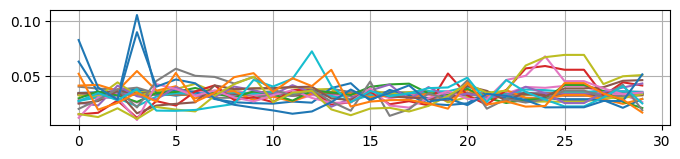

In [15]:
plt.gcf().set_size_inches(8, 1.5)
np_at = attentions[:,0].cpu().numpy()

for jx in range(num_heads):
    plt.plot(np_at[:,jx], label=jx)

plt.grid()
plt.show()

In [16]:
print(attentions.shape)
attentions[:,0].shape

torch.Size([30, 1, 32])


torch.Size([30, 32])

In [17]:
def get_video_label(test_label):
    # 각 인덱스에 해당하는 레이블의 이름
    label_names = ['A-line', 'B-lines', 'Consolidation', 'Pleural effusion']
    
    # test_label이 tensor인지 확인하고 list로 변환
    if isinstance(test_label, torch.Tensor):
        test_label = test_label.tolist()
    
    labels = [label_names[idx] for idx, value in enumerate(test_label) if value == 1.0]
    
    return f"{', '.join(labels)}"

In [18]:
result = get_video_label(test_label)
result

'A-line'

In [19]:
attentions[:, 0].shape

torch.Size([30, 32])

In [ ]:
# attention 값의 평균을 통해 각 프레임의 중요도를 계산
# mean_attentions = attentions[:, 0].mean(dim=1)  # torch.Size([30])
frame_attention_sum = attentions[:, 0].sum(dim=1)  # torch.Size([30])
frame_attention_mean = frame_attention_sum / 32

# 가장 높은 attention을 갖는 상위 10개의 프레임 인덱스 선택
top_frame_indices = torch.topk(frame_attention_mean, k=10).indices  # torch.Size([10])

# 상위 10개의 프레임 출력
fig, axs = plt.subplots(2, 5, figsize=(15, 6))  # 2행 5열로 출력

for i, idx in enumerate(top_frame_indices):
    ax = axs[i // 5, i % 5]
    ax.imshow(test_img[idx, 0].cpu(), cmap='gray')  # 단일 채널 이미지를 표시
    ax.set_title(f"Frame {idx.item()} (Attention: {frame_attention_mean[idx]:.2f})", fontsize=10)
    ax.axis('off')

fig.suptitle(f'Top-10 frame (video labels : {result})', fontsize=16)
plt.subplots_adjust(wspace=0.3, hspace=0.5)  # 가로, 세로 여백 조정
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import torch

# attention 값의 합을 통해 각 프레임의 중요도를 계산
frame_attention_sum = attentions[:, 0].sum(dim=1)  # torch.Size([30])
frame_attention_mean = frame_attention_sum / 32

# 가장 높은 attention을 갖는 상위 10개의 프레임 인덱스 선택
top_frame_indices = torch.topk(frame_attention_mean, k=10).indices  # torch.Size([10])

# 폰트 크기 설정
plt.rcParams['font.size'] = 12

# 1행 10열의 서브플롯 생성
fig, ax = plt.subplots(nrows=1, ncols=10, sharex=True, sharey=True)
scaling_factor = 1.5
fig.set_size_inches(scaling_factor * 10 / 1.13, scaling_factor * 1)

# 제목 설정
result = get_video_label(test_label)
file_name = test_path.split('/')[-1].split('.')[0]

fig.suptitle(f'Top-10 frame ({file_name} : {result})', fontsize=12)

# 각 프레임을 서브플롯에 출력
for i, idx in enumerate(top_frame_indices):
    a = ax[i]
    a.imshow(test_img[idx, 0].cpu(), cmap='gray')
    a.set_xlabel(f'{i}', fontsize=10)
    a.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)

# Adjust the top margin to increase space between title and images
fig.subplots_adjust(top=0.85, wspace=0, hspace=0)

# Adjust the position of the bottom text
# fig.text(0.5, -0.02, 'Top-k frame', ha='center', fontsize=12)

# Show the plot
plt.show()

In [ ]:
save_root_dir = f'/home/work/LUS/Results/clip_base/attention_results/temporally_separated_test_set/{model_name}_{video_batch_size}_{encoder_name}_{encoder_batch_size}_fold{fold_num}'
top_k = 10

model.eval() 
with torch.no_grad():
    for data in tqdm(test_dataloader, desc="Testing", unit="batch"):    
        test_img, test_label, test_path = data
        
        file_name = test_path[0].split('/')[-1].split('.')[0]
        
        test_img, test_label = test_img.float().to(device), test_label

        test_output, attentions = model(test_img, num_frames)

        sigmoid = nn.Sigmoid()
        test_output = sigmoid(test_output)
    #     print(test_output)
        test_preds_np = test_output[0].data.cpu().numpy()
        print(test_preds_np)

        test_preds_np = np.where(test_preds_np >= best_val_thres, 1, 0)

        # Calculate the importance of each frame through the sum of attention values
    #     print(attentions.shape)
        frame_attention_sum = attentions[:, 0].sum(dim=1)  # torch.Size([30])
        frame_attention_mean = frame_attention_sum / 32

        # Select top-k frames with the highest attention
        top_frame_indices = torch.topk(frame_attention_mean, k=top_k).indices  # torch.Size([10])

        # Set font size
        plt.rcParams['font.size'] = 12

        # Create subplots (1 row, 10 columns)
        fig, ax = plt.subplots(nrows=1, ncols=top_k, sharex=True, sharey=True)
        scaling_factor = 1.5
        fig.set_size_inches(scaling_factor * top_k / 1.13, scaling_factor * 1)

        # Set the title
        int_test_label_lst = test_label[0].int().tolist()

        result = get_video_label(test_label[0])
        fig.suptitle(f'Top-{top_k} frames ({file_name} : {result})', fontsize=12)

        # Plot each frame in the subplots
        for i, idx in enumerate(top_frame_indices):
            a = ax[i]
            a.imshow(test_img[idx, 0].cpu(), cmap='gray')
            a.set_xlabel(f'{i}', fontsize=10)
            a.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)

        # Adjust the top margin to increase space between title and images
        fig.subplots_adjust(top=0.85, wspace=0, hspace=0)

        # Save the plot
        os.makedirs(save_root_dir, exist_ok=True)  
        save_path = os.path.join(save_root_dir, f'{file_name}_{int_test_label_lst}_{list(test_preds_np)}.png')
        plt.savefig(save_path, bbox_inches='tight')  # Save with high resolution
    #     plt.savefig(save_path, bbox_inches='tight', dpi=300) 

        # Show the plot
        plt.show()

        print(f"Plot saved at: {save_path}")

In [35]:
test_label

[tensor([1., 0., 0., 0.])]